# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 5: Retrieval‑Augmented Generation (RAG)
### Оценивание и штрафы

Максимально допустимая оценка за работу — __10 баллов__.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 16.12.24 23:59__ \
__Жесткий дедлайн 19.12.24 23:59__

### О задании

В этом домашнем задании вам предлагается реализовать ассистента для кулинарных советов с помощью RAG, который помимо всего прочего может ходить в итернет за дополнительной информацией. Всю логику системы нужно будет написать самостоятельно без специализорованных библиотек. Мы разделили ее на несколько логических компонент, каждой из которых будет отведено отдельное задание:
1. Векторная база данных с быстрым семантическим поиском
2. Разбиение текстов на куски.
3. Ранжирование документов по релевантности
4. Формирование контекста для модели и генерация ответа

### О данных

В качестве базы данных мы будем использовать пользовательские рецепты с сайта "Поваренок.Ру". Они получены с помощью веб-парсинга сайта, поэтому местами тексты недостаточно чистые. Всего в датасете содержится 84130 рецептов.

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import os

# Установка рабочей директории
cur_directory = "/content/drive/MyDrive/Colab Notebooks/hw_5-last"
os.chdir(cur_directory)

print("Работаем в директори", os.getcwd())

Работаем в директори /content/drive/MyDrive/Colab Notebooks/hw_5-last


In [48]:
!pip -q install datasets

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

### Загрузка датасета и модели

Таблица с рецептами хранится в файле `povarenok.csv`. Каждая запись содержит название рецепта, список ингредиентов и сам рецепт. Несмотря на то, что всего датасете хранится 84130 записей, в рамках этого задания мы будем работать с первыми 10-ю тысячами для того, чтобы все работало быстрее. При желании вы можете взять больше.

In [50]:
dataet_path = 'povarenok.csv'
dataset = load_dataset('csv', data_files=[dataet_path], split='train')


In [51]:
dataset = dataset.select(range(40000))

In [52]:
dataset.to_csv('povarenok_small.csv')

Creating CSV from Arrow format:   0%|          | 0/40 [00:00<?, ?ba/s]

79334716

In [53]:
from datasets import load_dataset
dataet_path = 'povarenok_small.csv'
dataset = load_dataset('csv', data_files=[dataet_path], split='train')
# dataset = dataset.select(range(1000))
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['name', 'ingredients', 'text'],
    num_rows: 40000
})

In [54]:
dataset[0]

{'name': 'Густой молочно-клубничный коктейль',
 'ingredients': "['Молоко', 'Клубника', 'Сахар']",
 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}

Посмотрим на распределение длин текстов. Нам важно знать с чем мы имеем дело, ведь RAG подразумевает, что мы будем подавать тексты на вход модели.

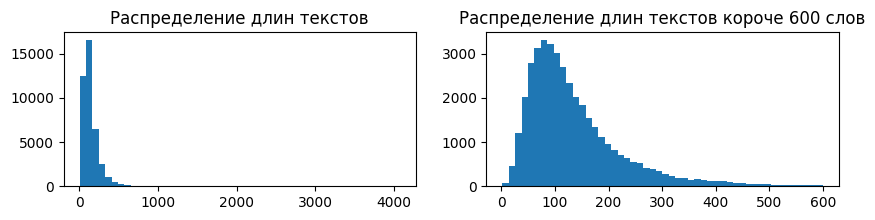

In [55]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Распределение длин текстов')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 600], bins=50)
plt.title('Распределение длин текстов короче 600 слов')

plt.show()

Видим, что тексты часто довольно длинные. Поэтому смухлевать не получится и перед векторизацией нужно будет разбивать каждый текст на небольшие куски, чтобы не перегружать контекст модели и чтобы потерять важную информацию при векторизацци текстов на этапе складывания их в векторную базу данных.

Приступим к реализации RAG.

## Retrieval‑Augmented Generation

В качестве основы для ассистента возьмите модель [`Qwen/Qwen2-1.5B-Instruct`](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) из huggingface. Важно, что это `Instruct` модель, то есть она предлазначена для общения в формате диалога.

__Задание 0 (0 баллов).__ Проверьте, как модель отвечает на кулинарные вопросы без RAG. Это необходимо сделать, чтобы понять, нужен ли вообще RAG для данной задачи.

In [56]:
from transformers import  AutoModelForCausalLM, AutoTokenizer

In [57]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [58]:
# Загрузка модели и токенизатора

model_name = "Qwen/Qwen2-1.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [59]:
from transformers import pipeline

gen_pipeline = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    device=device
)

In [60]:
prompt = "Напиши мне рецепт вкусного и полезного завтрака для двоих"

messages = [
    {"role": "system", "content": "Ты лучший кулинарный эксперт, который дает хорошие советы для начинающих кулинаров"},
    {"role": "user", "content": prompt}
]

response = gen_pipeline(messages, max_new_tokens=2048, do_sample=True, temperature=0.5, top_p=0.9)[0]['generated_text'][-1]['content']
print(response)

Конечно! Вот простой и здоровый рецепт завтрака для двух человек:

**Салат из брокколи с овощами и яйцом**

**Ингредиенты:**
- 1 лист брокколи
- 2 средних помидора
- 3 зубчика чеснока
- 1/4 чайной ложки черного перца
- 1/4 чайной ложки молотого кардамона
- Соль и перец по вкусу
- Оливковое масло

**Рецепт:**

1. Брокколи нужно промыть под холодной водой и нарезать на тонкие полоски.
2. Помидоры, чеснок и кардамон можно очистить от кожицы и нарубить в пюре.
3. В сковороде加热 оливковое масло и обжариваем чесночное пюре до мягкости. 
4. Добавляем брокколи и оставшиеся овощи, перемешиваем и продолжаем обжаривать на медленном огне около 5 минут, пока не начнут готовиться.
5. Когда овощи станут мягкими, добавляем порезанные яйца и оставьте их еще на 2-3 минуты, чтобы они немного остудели.
6. Закрываем крышкой и оставляете на пару минут, чтобы яичница приобрела нежную текстуру.
7. Перемешайте все ингредиенты вместе, добавьте соль и перец по вкусу.

Это вкусный и полезный салат, богатый белками

**Видно, что модель может справляться с темой кулинарии, продолжаем копаться в задаче**

### Locality Sensitive Hashing (LSH)

В RAG для каждого запроса необходимо искать релевантные документы по векторной базе данных. Так как документов очень много, подсчет релевантности для каждого из них будет занимать очень много времени. Поэтому нам важно, чтобы поиск был быстрым. Для достижения этого мы даже готовы немного пожертвовать точностью.

В этой секции вам предстоит реализовать [Locality Sensitive Hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing).

Идея LSH довольна проста. Разделим все векторы из базы данных на группы, состоящие из похожих векторов. В начале поиска определим группу, которая соответствует вектору запроса и будем считать релевантность только для объектов из этой группы. Для разбиения на группы мы введем несколько хеш-функций. Каждая их них будет строиться по следующему алгоритму:
1. Сгенерируем $k$ случайных векторов (векторы нормали гиперплоскости)
2. Для отдельной точки (вектора) в базе данных и вектора нормали запишем 1, если точка лежит над соответствующей гиперплоскостью. В обратном случае запишем 0.
3. Повторим процедуру для всех точек и векторов нормали. Так мы для каждой точки получим список из $k$ 0 и 1, который и будет хешем.
4. Запишем в хеш-таблицу найденные точки для каждого хеша.
5. Повторим шаги 1-4 $L$ раз и получим $L$ разных хеш-таблиц.

Теперь для каждого нового вектора $q$ мы можем очень быстро найти набор векторов похожих на него. Для этого посчитаем хеши запроса в каждой хеш-таблице и возьмем все точки, у которых хеш совпал c $q$ хотя бы в одной из них. Затем переранжируем найденные точки по релевантности (расстоянию до вектора запроса) и оставим заданное число самых близких.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

__Задание 1 (3 балла).__ Реализуйте векторную базу данных LSH поиском. База данных должна уметь добавлять новые векторы, а так же по входному вектору быстро находить ближайшие к нему. Во время создании базы данных сгенерируйте необходимое число хеш-функций. Подумайте о том, как выбрать количество хеш-таблиц и число случайных векторов, а так же о том, из какого распределения брать эти случайные векторы. При добавлении нового вектора в базу данных, считайте для него хеш и записывайте, каким группам от принадлежит.

Постарайтесь оптимизировать код и не забудьте протестировать, что ваш LSH работает так, как надо. Проще всего это сделать, построив базу данных с точками на двумерной плоскости. Также сравните скорость LSH поиска с полным перебором. Если вы все сделали правильно, то для 1000 точек вы должны получить ускорение поиска примерно в 4 раза.

In [61]:
from LSH import LSH

**Проверка работы LSH на векторах слов**

In [62]:
from sentence_transformers import SentenceTransformer
import torch

# модель для эмбеддингов
embedding_model = SentenceTransformer("intfloat/multilingual-e5-large", model_kwargs={'torch_dtype': torch.float16})

In [63]:
words = ['собака', 'кошка', 'мальчик', 'женщина', 'мужчина', 'король', 'бегемот', 'солнце']

vectors = embedding_model.encode(words, batch_size=512, device=device, normalize_embeddings=True, show_progress_bar=True).tolist()

lsh = LSH(dim=len(vectors[0]), num_tables=8, num_hashes=8)

for i, vector in enumerate(vectors):
    lsh.add_vector(vector, i)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
query = 'звезда'
query_vector = embedding_model.encode(
        [query], batch_size=1, device=device, normalize_embeddings=True
    ).tolist()[0]

results = lsh.query(query_vector, max_results=5)
print(f"Похожие слова на '{query}':", [words[i[0]] for i in results])

Похожие слова на 'звезда': ['солнце', 'женщина', 'собака', 'король', 'мужчина']


In [20]:
query = 'хот-дог'
query_vector = embedding_model.encode(
        [query], batch_size=1, device=device, normalize_embeddings=True
    ).tolist()[0]

results = lsh.query(query_vector, max_results=5)
print(f"Похожие слова на '{query}':", [words[i[0]] for i in results])

Похожие слова на 'хот-дог': ['собака', 'кошка', 'король', 'мужчина', 'женщина']


**Получаем вполне осмысленные результаты для двух примеров**

**Сравнение скорости поиска**

In [21]:
import time
import numpy as np
from collections import defaultdict

# генерируем векторы для теста скорости работы
np.random.seed(42)
num_vectors = 10000
dim = 1000
vectors = [np.random.rand(dim) for _ in range(num_vectors)]

# база lsh
lsh = LSH(dim=dim, num_tables=5, num_hashes=5)

# создание базы
for i, vec in enumerate(vectors):
    lsh.add_vector(vec, i)

# вектор запроса
query_vector = np.random.rand(dim)

# поиск lsh
start_time = time.time()
lsh_results = lsh.query(query_vector, max_results=5)
lsh_time = time.time() - start_time

# полный перебор
start_time = time.time()
brute_force_results = []
for i, vec in enumerate(vectors):
    similarity = lsh.cosine_similarity(query_vector, vec)
    brute_force_results.append((i, similarity))
brute_force_results = sorted(brute_force_results, key=lambda x: x[1], reverse=True)[:5]
brute_force_time = time.time() - start_time


print(f"Время LSH: {lsh_time:.5f} сек")
print(f"Время полного перебора: {brute_force_time:.5f} сек")
print(f"Прирост скорости в {brute_force_time / lsh_time:.2f} раз")

Время LSH: 0.07676 сек
Время полного перебора: 0.14925 сек
Прирост скорости в 1.94 раз


**Прирост в скорости становится более существенным при увеличеннии размерности данных и их количестве**

### Разбиение текста на куски

Так как некоторые тексты довольно длинные, если мы будем кодировать их целиком одним вектором, то часть информации потеряется. Вектор все таки имеет ограниченный размер. Чтобы не терять информацию, мы поделим текст на куски и будем кодировать каждый кусок отдельно.

__Задание 2 (2 балла).__ Реализуйте [рекурсивное разбиение](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) текста с уровнями `["\n\n", "\n", " ", ""]`. Добавьте пересечение между кусками для уровней `[" ", ""]`. То есть если целый абзац помещается в один кусок, то пересекать его ни с чем не надо (в нем содержится законченная мысль), а если абзац не влезает и его приходится делить по словам (или символам), то нужно добавить пересечение со словами из соседних кусков того же абзаца.

Значения для максимального размера каждого куска и длины пересечения выберите самостоятельно. Надежнее всего брать размер пересечения равным половине длины куска.

**Сравним разбиение с встроенной функцией из  библиотеки LangChain**

In [22]:
text = """Однажды Иван-царевич отправился в дальнее путешествие.
Он шёл через густые леса, пересекал быстрые реки и встречал разных животных.
В одном из лесов его встретил Серый волк. Волк был умный и мог говорить человеческим языком. Он предложил Ивану помощь в его приключениях.
Иван согласился, и они вместе отправились вперёд. По дороге Ивану предстояло преодолеть множество трудностей, но с помощью волка он справлялся с ними легко.
"""

In [23]:
print(text)

Однажды Иван-царевич отправился в дальнее путешествие.
Он шёл через густые леса, пересекал быстрые реки и встречал разных животных.
В одном из лесов его встретил Серый волк. Волк был умный и мог говорить человеческим языком. Он предложил Ивану помощь в его приключениях.
Иван согласился, и они вместе отправились вперёд. По дороге Ивану предстояло преодолеть множество трудностей, но с помощью волка он справлялся с ними легко.



**Разбиение на чанки без перекрытия**

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from my_splitter import MyRecursiveTextSplitter

# Без пересечения
CHUNK_SIZE = 100
CHUNK_OVERLAP = 0

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CHUNK_SIZE,
    chunk_overlap  = CHUNK_OVERLAP,
)

lang_chain_texts = text_splitter.split_text(text)


my_text_splitter = MyRecursiveTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
my_chunks = my_text_splitter.split_text(text)


for i, chunk in enumerate(my_chunks):
    print(f"Части в моем разбиении и разбиении lang_chain без пересечения: \n")
    print(chunk)
    print(lang_chain_texts[i])

    print()
    print('------------------------')

Части в моем разбиении и разбиении lang_chain без пересечения: 

Однажды Иван-царевич отправился в дальнее путешествие.
Однажды Иван-царевич отправился в дальнее путешествие.

------------------------
Части в моем разбиении и разбиении lang_chain без пересечения: 

Он шёл через густые леса, пересекал быстрые реки и встречал разных животных.
Он шёл через густые леса, пересекал быстрые реки и встречал разных животных.

------------------------
Части в моем разбиении и разбиении lang_chain без пересечения: 

В одном из лесов его встретил Серый волк. Волк был умный и мог говорить человеческим языком. Он
В одном из лесов его встретил Серый волк. Волк был умный и мог говорить человеческим языком. Он

------------------------
Части в моем разбиении и разбиении lang_chain без пересечения: 

предложил Ивану помощь в его приключениях.
предложил Ивану помощь в его приключениях.

------------------------
Части в моем разбиении и разбиении lang_chain без пересечения: 

Иван согласился, и они вместе

**Разбиение на чанки с перекрытием**

In [25]:
# С пересечением 50

CHUNK_SIZE = 100
CHUNK_OVERLAP = 50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CHUNK_SIZE,
    chunk_overlap  = CHUNK_OVERLAP,
)

lang_chain_texts = text_splitter.split_text(text)

my_text_splitter = MyRecursiveTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
my_chunks = my_text_splitter.split_text(text)

for i, chunk in enumerate(my_chunks):
    print(f"Части в моем разбиении и разбиении lang_chain с пересечением 50: \n")
    print(chunk)
    print(lang_chain_texts[i])
    print()
    print('------------------------')

Части в моем разбиении и разбиении lang_chain с пересечением 50: 

Однажды Иван-царевич отправился в дальнее путешествие.
Однажды Иван-царевич отправился в дальнее путешествие.

------------------------
Части в моем разбиении и разбиении lang_chain с пересечением 50: 

Он шёл через густые леса, пересекал быстрые реки и встречал разных животных.
Он шёл через густые леса, пересекал быстрые реки и встречал разных животных.

------------------------
Части в моем разбиении и разбиении lang_chain с пересечением 50: 

В одном из лесов его встретил Серый волк. Волк был умный и мог говорить человеческим языком. Он
В одном из лесов его встретил Серый волк. Волк был умный и мог говорить человеческим языком. Он

------------------------
Части в моем разбиении и разбиении lang_chain с пересечением 50: 

был умный и мог говорить человеческим языком. Он предложил Ивану помощь в его приключениях.
был умный и мог говорить человеческим языком. Он предложил Ивану помощь в его приключениях.

-------------

**Все работает!**

## RAG

Наконец мы можем начать собирать систему RAG. Для начала соберем векторую базу данных из кусков рецептов. Для получения эмбеддингов текстов возьмите модель [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), она создана специально для этой задачи и хорошо работает с русским языком.

__Задание 3 (1 балл).__ Соберите векторую базу данных с помощью написанных вами функций. Процесс не должен занимать много времени с GPU, но мы рекомендуем сохранить результат на диск, чтобы не векторизовать весь датасет заново при перезапуске ядра. Проверьте, что по запросу возвращаются релевантные тексты.

In [26]:
from sentence_transformers import SentenceTransformer
import torch

# модель для эмбеддингов
embedding_model = SentenceTransformer("intfloat/multilingual-e5-large", model_kwargs={'torch_dtype': torch.float16})

In [27]:
from tqdm import tqdm

# делитель рецептов на чанки
text_splitter = MyRecursiveTextSplitter(chunk_size=200, chunk_overlap=100)


# делим описание рецепта на чанки
def split_text_into_chunks(example, index):
    return {"id": index, 'name': example["name"], "chunks": text_splitter.split_text(example["text"]), 'ingredients': example['ingredients']}


text_chunks = dataset.map(
    split_text_into_chunks,
    with_indices=True,
    batched=False
)


# каждому чанку сопоставляем, какому номеру рецепта он принадлежит
text_chunks_numbered = []

for chunk_dict in text_chunks:
    id = chunk_dict['id']
    chunks = chunk_dict['chunks']
    name = chunk_dict['name']
    ingredients = chunk_dict['ingredients']
    for chunk in chunks:
        text_chunks_numbered.append((id, name, chunk, ingredients))

ids, names, text_chunks, ingredients = zip(*text_chunks_numbered)

# проверка
for id, name, chunk, ingredient in zip(ids, names, text_chunks, ingredients):
    if id == 4:
      print(f"id: {id}, Блюдо: {name}, Чанк: {chunk}, 'Ингредиенты: {ingredient}")

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

id: 4, Блюдо: Рецепт вишневой наливки, Чанк: В бутыль заложить вишни, косточки, пряности и залить водкой, настаивать 2 недели в темном месте, помешивая. После, отфильтровать, вишни отжать, добавить сахара и еще настоять полторы -2 недели в, 'Ингредиенты: ['Вишня', 'Водка', 'Сахар', 'Кости', 'Корица', 'Гвоздика']
id: 4, Блюдо: Рецепт вишневой наливки, Чанк: помешивая. После, отфильтровать, вишни отжать, добавить сахара и еще настоять полторы -2 недели в темном месте, время от времени встряхивая банку. Когда сахара раствориться, и выпадет осадок, вишневая, 'Ингредиенты: ['Вишня', 'Водка', 'Сахар', 'Кости', 'Корица', 'Гвоздика']
id: 4, Блюдо: Рецепт вишневой наливки, Чанк: месте, время от времени встряхивая банку. Когда сахара раствориться, и выпадет осадок, вишневая наливка готова., 'Ингредиенты: ['Вишня', 'Водка', 'Сахар', 'Кости', 'Корица', 'Гвоздика']


In [28]:
# собираем id_to_name

id_to_name = {id: name for id, name in zip(ids, names)}

id_to_name[4]

'Рецепт вишневой наливки'

In [29]:
# собираем id_to_ingredients

id_to_ingredients = {id: ingredient for id, ingredient in zip(ids, ingredients)}
id_to_ingredients[4]

"['Вишня', 'Водка', 'Сахар', 'Кости', 'Корица', 'Гвоздика']"

In [30]:
# уникальные названия блюд

unique_names = list(id_to_name.values())
unique_names[4]

'Рецепт вишневой наливки'

In [31]:
from collections import defaultdict

# собираем id_to_chunks
id_to_chunks = defaultdict(list)

for id, chunk in zip(ids, text_chunks):
    id_to_chunks[id].append(chunk)

id_to_chunks[4]

['В бутыль заложить вишни, косточки, пряности и залить водкой, настаивать 2 недели в темном месте, помешивая. После, отфильтровать, вишни отжать, добавить сахара и еще настоять полторы -2 недели в',
 'помешивая. После, отфильтровать, вишни отжать, добавить сахара и еще настоять полторы -2 недели в темном месте, время от времени встряхивая банку. Когда сахара раствориться, и выпадет осадок, вишневая',
 'месте, время от времени встряхивая банку. Когда сахара раствориться, и выпадет осадок, вишневая наливка готова.']

In [32]:
# получаем эмбединг для каждого названия блюда

vectors = embedding_model.encode(unique_names, batch_size=512, device=device, normalize_embeddings=True, show_progress_bar=True).tolist()

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [33]:
# добавляем векторы в LSH

lsh = LSH(dim=len(vectors[0]), num_tables=20, num_hashes=20)

for i, vector in tqdm(enumerate(vectors), total=len(vectors), desc="Добавление векторов в LSH"):
    lsh.add_vector(vector, vector_id=i)


Добавление векторов в LSH: 100%|██████████| 40000/40000 [02:37<00:00, 253.95it/s]


In [34]:
# делаем поиск по запросу

def search_recipes_by_name(query, embedding_model, lsh, names, text_chunks_numbered, device="cpu", max_results=3):
    # эмбеддинг запроса
    query_vector = embedding_model.encode(
        [query], batch_size=1, device=device, normalize_embeddings=True
    ).tolist()[0]

    # поиск ближайших
    query_res = lsh.query(query_vector, max_results=max_results)

    # формирование ответа
    print("Результаты поиска:\n")
    for result_id, sim in query_res:
        # название блюда
        result_name = id_to_name[result_id]

        # получаем чанки рецепта
        recipe_chunks = [chunk for _, name, chunk, _ in text_chunks_numbered if name == result_name]

        # вывод результата
        print(f"Номер блюда в базе: {result_id}, Похожее блюдо: {result_name}, Cходство: {round(sim, 3)}")
        print("Рецепт:")
        for chunk in recipe_chunks:
            print(f"- {chunk}")
        print("Ингредиенты:")
        print(id_to_ingredients[result_id])
        print("\n" + "-" * 50 + "\n")


query = 'Квас'

search_recipes_by_name(
    query=query,
    embedding_model=embedding_model,
    lsh=lsh,
    names=names,
    text_chunks_numbered=text_chunks_numbered,
    device=device,
    max_results=3
)

Результаты поиска:

Номер блюда в базе: 871, Похожее блюдо: Овсяный квас, Cходство: 0.908
Рецепт:
- Прежде всего идём на рынок и покупаем овёс (у нас продаётся для посадки и для лечения. Ессстесственно выбираем для лечения- он чище.) Приносим овёс домой, и тщательно и очень долго его промываем (кто
- выбираем для лечения- он чище.) Приносим овёс домой, и тщательно и очень долго его промываем (кто его знает, чем его травили.) После этого засыпаем овёс в3-х литровую банку, добавляем сахар, и
- (кто его знает, чем его травили.) После этого засыпаем овёс в3-х литровую банку, добавляем сахар, и заливаем эту лабуду тёплой водой (помешивая ложкой). Накрываем салфеткой и оставляем на 4 дня. Всё
- заливаем эту лабуду тёплой водой (помешивая ложкой). Накрываем салфеткой и оставляем на 4 дня. Всё это время наблюдаем как овсинки плавают вверх-вниз. Через четыре дня сливаем густоватый кисель в
- это время наблюдаем как овсинки плавают вверх-вниз. Через четыре дня сливаем густоватый кисель в унитаз,

**Видно, что для запроса можем получить релевантные ответы на основе построенной базы**

### Формирование контекста для модели и генерация ответа

Из всех компонент RAG эта самая творческая. Надо придумать промпт, который будет лучше всего помогать модели генерировать ответ.

__Задание 4 (1 балл).__ Напишите функцию для генерации ответа по текстовому запросу в парадигме RAG. Найдите релевантные документы и соберите из них промпт, объяснив дополнительно модели, что от нее требуется. Количество текстов в промпте ограничивайте отбирая топ самых релевантных. Заметьте, что в нашем датасете помимо рецепта есть список ингредиентов и название блюда. Подумайте о том, как можно их использовать. Предайте промпт в модель для получения ответа. Подберите гиперпараметры генерации, чтобы контролировать разнообразие. Помните, что модель должна строго соответствовать инструкциям, не придумывать факты и не генерировать то, что от нее не требуется. Продемонстрируйте ваши результаты на 3-5 примерах.

In [35]:
# модифицируем прудыдущю функию для передачи инфомарции в RAG

def search_recipes_by_name(query, embedding_model, lsh, names, text_chunks_numbered, device="cpu", max_results=3):
    query_vector = embedding_model.encode(
        [query], batch_size=1, device=device, normalize_embeddings=True
    ).tolist()[0]

    query_res = lsh.query(query_vector, max_results=max_results)

    result = []

    for result_id, sim in query_res:
        result_name = id_to_name[result_id]
        recipe_chunks = [chunk for _, name, chunk, _ in text_chunks_numbered if name == result_name]
        ingredients = id_to_ingredients[result_id]

        result.append({'dish_name': result_name,  'ingredients': ingredients, 'steps_for_cook': recipe_chunks})

    return result



query = 'Квас'

search_res = search_recipes_by_name(
    query=query,
    embedding_model=embedding_model,
    lsh=lsh,
    names=names,
    text_chunks_numbered=text_chunks_numbered,
    device=device,
    max_results=3
)

search_res[0]

{'dish_name': 'Овсяный квас',
 'ingredients': "['Овес', 'Вода', 'Сахар']",
 'steps_for_cook': ['Прежде всего идём на рынок и покупаем овёс (у нас продаётся для посадки и для лечения. Ессстесственно выбираем для лечения- он чище.) Приносим овёс домой, и тщательно и очень долго его промываем (кто',
  'выбираем для лечения- он чище.) Приносим овёс домой, и тщательно и очень долго его промываем (кто его знает, чем его травили.) После этого засыпаем овёс в3-х литровую банку, добавляем сахар, и',
  '(кто его знает, чем его травили.) После этого засыпаем овёс в3-х литровую банку, добавляем сахар, и заливаем эту лабуду тёплой водой (помешивая ложкой). Накрываем салфеткой и оставляем на 4 дня. Всё',
  'заливаем эту лабуду тёплой водой (помешивая ложкой). Накрываем салфеткой и оставляем на 4 дня. Всё это время наблюдаем как овсинки плавают вверх-вниз. Через четыре дня сливаем густоватый кисель в',
  'это время наблюдаем как овсинки плавают вверх-вниз. Через четыре дня сливаем густоватый кисель в

In [36]:
from transformers import pipeline

# строим полную систему для ответов по базе

generation_pipeline = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    device=device
)

def llm_answer(query, context, temperature=0.7, top_p=0.9, max_new_tokens=1024):

    recipes = "\n".join([
        f"- {recipe['dish_name']}\n  Ингредиенты: {''.join(recipe['ingredients'])}\n  Шаги: {', '.join(recipe['steps_for_cook'])}"
        for recipe in context
    ])

    prompt = f"""
Вопрос: {query}

Названия блюд, ингридиенты для приготовления и шаги готовки:
{recipes}
"""


    messages = [
        {"role": "system", "content": "Ты самый шутливый ассистент, который умеет давать советы по готовке. Тебе будет известна информация о блюдах, ингридиентах и шагах приготовления этого блюда. Ты должен дать ответ на основе этой информации. Начни ответ с приветствия. Потом укажи, о каком блюде пойдет речь, потом укажи необходимые ингоидиенты и после этого описывай шаги приготовления. Соблюдай правила русского языка"},
        {"role": "user", "content": prompt},
    ]

    output = generation_pipeline(messages, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature, top_p=top_p)

    return output[0]['generated_text'][-1]['content']



def predict(query):
    print("Поиск рецептов...")
    context = search_recipes_by_name(
        query=query,
        embedding_model=embedding_model,
        lsh=lsh,
        names=names,
        text_chunks_numbered=text_chunks_numbered,
        device=device,
        max_results=3
    )

    print(f"Найдено рецептов: {len(context)}")
    print(f"Контекст: {context} \n")
    print(f"Думаю над рецептом... \n")
    answer = llm_answer(query, context)

    return answer


query = 'каша из топора'

print(predict(query))


Поиск рецептов...
Найдено рецептов: 3
Контекст: [{'dish_name': 'Запеканка из топора', 'ingredients': "['Картофель', 'Тунец', 'Чеснок', 'Соевый соус', 'Укроп', 'Сливки', 'Смесь перцев', 'Масло оливковое', 'Пармезан', 'Соль', 'Грибы', 'Курица']", 'steps_for_cook': ['И вот давеча мой инквизиторский взгляд выцепил: начавшую морщиться картошку (3 штуки), 6 грибных ножек (шампиньоны), сливки с истекающим уже сроком годности и начавшие заветриваться кусочки куриного', '(шампиньоны), сливки с истекающим уже сроком годности и начавшие заветриваться кусочки куриного мяса. Как из этого соорудить ужин, причeм так, чтобы муж не организовал второй бунт на броненосце', 'мяса. Как из этого соорудить ужин, причeм так, чтобы муж не организовал второй бунт на броненосце Потeмкине? А если я вам скажу, что этот ужин из остатков был праздничным, в честь годовщины моего', 'Потeмкине? А если я вам скажу, что этот ужин из остатков был праздничным, в честь годовщины моего переезда к мужу? Allora... Картошку — в

**Комментарий**

- Добавил контекста: название блюда, продукты для приготовления и пошаговая инструкция. Постарался указать  в системном промпте пайплайн по которому модель выдает ответ, попросил соблюдать нормы языка.

- В некоторых случаях модели выдавала, что в контексте не содержится необходимая информация и просила дополнить запрос.
- Много элементарных грамматических и лексических ошибок при генерации.

- Для хорошей генерации по базе требуется придумать хорошие эвристики отбора кондидатов для составления контекста

- На разные запросы приходилось разное время для генерации ответа

- Есть так же рецепты несуществующих блюд по типу свиных крылышек и каши из топора, что следует фильторвать в проде или давать шутливый ответ на абсурдные запросы пользователей

- Можно хэшировать частые запросы и ответы для более быстрой генерации

- Нужно внимательно изучать базу знани, с которой работает модель, чтобы информация оттуда не вводила алгоритм в заблуждение

- Неплохой результат был с молочными коктелями в последнем примере, который описан ниже. За исключением того, что его советовали для холодных дней

### **Примеры вопросов и ответов**
- **Вопрос**: Вишневая наливка
- **Ответ**:  
  Отличная идея сделать вишневую наливку! Это настоящий сказочный напиток, который может стать вашим любимым. Как только вы налейте вишневую наливку, она напомнит вам о теплом летнем вечере, когда в воздухе цвести вишня.

  Приготовьте ее так, как указано в рецепте: заложите вишню, косточки, пряности и залейте водкой. Через две недели, помешивая, отфильтруйте и добавьте сахар. Промучитесь над этим процессом еще полторы-двух недели, встряхивая банку. После этого, когда сахар растворится и осадок выпадет, ваша вишневая наливка готова!

  Итого, всего лишь три этапа: подготовка ингредиентов, залить водкой и стоять над банкой, встряхивая, и надеясь, что все получится. Что же, попробуйте это и посмотрите, что получится!

- **Вопрос**: как приготовить свиные крылышки в соусе барбекю

- **Ответ**:

  Куриные крылышки в соусе барбекю - это отличная идея для праздничного стола! Вот как сделать их:

  Ингредиенты:
  - 500 г свиных крылышек
  - 3 зубчика душистого переца
  - 1/4 столовой ложки горчицы
  - 1/4 столовой ложки сахара
  - 1/4 столовой ложки молока
  - 1/4 столовой ложки воды
  - 2 столовых ложки сметаны
  - 2 столовых ложки соуса барбекю
  - 1 столовая ложка куркумы

  Шаги готовки:
  1. Отварите свиные крылышки в кипящей воде около 20 минут, затем отложите в холодную воду.

  2. Разделите крылышки на две части и очистите их от кожи и жира.

  3. Установите сковородку с небольшим количеством масла на средний огонь. Добавьте нарезанный перец, горчицу, сахар, молоко и воду. Ставьте на медленный огонь и доведите до кипения.

  4. Добавьте крылышки в сковороду и посолите, чтобы им было достаточно соли. Проводите пару минут, пока крылышки не станут мягкими и немного золотистыми.

  5. Добавьте сметану и соус барбекю. Перемешайте все вместе и продолжайте обжаривать на медленном огне, пока соус не станет прозрачным.

  6. Выключите огонь и дайте крылышкам остыть перед подачей.

  Приятного аппетита!

  Отличного дня!


  - **Вопрос**: рецепт шоколадного и ванильного молочного коктеля

  - **Ответ**:

  Думаю над рецептом...

  Извините за путаницу, но я не могу предложить вам рецепт "шоколадного и ванильного молочного кокеля". Я могу предложить вам рецепт шоколадного и ванильного молочных коктелей, если вы хотите их приготовить.

  Шоколадно-ванильный молочный коктейль:

  Бананы очистить и нарезать кружками. Шоколад, молоко и ванилин смешать в кастрюле. Ставить на медленный огонь, постоянно помешивать, доводя до кипения. После этого добавить бананы и взбить до однородности. Разливают по бокалам и в каждое бокале добавляют палочку корицы.

  Приятного аппетита!


  - **Вопрос**: каша из топора
  - **Ответ-1**:

  Здравствуйте! Вы задали вопрос о том, как приготовить кашу из топора. Вот несколько шагов:

    1. Возьмите топор и раздавите его.

    2. Разложите раздавленный топор по тарелке.

    3. Добавьте воду или другой жидкость, чтобы топор полностью растворился.

    4. Добавьте в кашу различные ингредиенты, такие как овощи, зерновые культуры, специи и т.д.

    5. Варите кашу на медленном огне, постоянно помешивая.

    6. После достижения нужной консистенции, снимайте кашу с огня.

    7. Подайте кашу по желанию.

  Помните, что при приготовлении любой кухонной процедуры важно соблюдать гигиену и безопасность, всегда используя рациональное количество продуктов. Удачи в приготовлении!


  - **Ответ-2**:

  Привет! Мы сегодня будем готовить кашу из топора. Для начала нам понадобятся следующие ингредиенты: топор, сливки, соль и перец.

  Шаги приготовления:

    1. Разложите топор в кастрюле и положите его в огонь.
    2. Поварите топор до тех пор, пока он не станет мягким и сочным.
    3. Положите в кастрюлю сливки и варите, пока сливки не начнут стекать.
    4. Перемешайте, добавьте соль и перец по вкусу, затем влейте еще немного воды.
    5. Постепенно добавляйте воду, пока топор не станет достаточно жидким.
    6. Когда топор будет готов, можно добавить к нему сливки, перемешать и подавать на стол.

  Приятного аппетита!


  - **Вопрос**: молочный коктель
  - **Ответ**:

  Доброго времени суток! Мы сегодня поговорим о молочном коктейле.

    Ингредиенты:
    1. Мороженое (4 штуки)
    2. Банан (1 штука)
    3. Сахар (2 чайные ложки)

    Шаги приготовления:

    1. В большой миске смешайте мороженое и сахар.
    2. Добавьте банан и перемешайте до образования однородной массы.
    3. Перелейте содержимое миски в блендер.
    4. Дайте ему поработать около минуты.
    5. Сбейте блендером до получения густой, но жидкой консистенции.
    6. Если вам не понравился текстура или вкус, добавьте немного молока.

    После того, как ваш молочный коктейль готов, вы можете его наслаждаться! Этот коктейль прекрасно подходит для холодных дней и отлично сочетается со свежими фруктами. Надеюсь, эта информация помогла вам подготовиться к своему ближайшему приготовлению молочных коктейлей. Удачи вам в кулинарной экспериментации!

### Поиск в интернете

Как вы должны были заметить, языковая модель с RAG работает куда лучше, чем без него. Несмотря на это, она все равно регулярно галлюционирует. Качество RAG подхода помимо самих компонент RAG во многом зависит от датасета и модели. Например, датасет с рецептами может не содержать каких-то фактов о самих блюдах, а некоторых блюд вообще может не быть. В таком случае модель не сможет правильно ответить на вопрос. Давайте улучшим качество формирования контекста, добавив возможность сестеме искать информацию в интернете.

__Задание 5 (2 балла).__ Модифицируйте процесс извлечения релевантных текстов следующим образом. Если в топе оказались тексты с недостаточно высокой (по порогу) похожестью на запрос, то замените их текстами, найденными по запросу в интернете, у которых похожесть достаточно высокая. Таким образом, модель всегда будет получать фиксированное число максимально релевантных текстов на вход.

При поиске в интернете мы будем пользоваться тем, что все поисковики сортируют выдачу по соответствию запросу. Значит мы можем взять наш запрос, вставить его в поисковик и пройти по выданным ссылкам, анализируя текст на каждой странице до тех пор, пока не наберем достаточное число релевантных текстов. Для хождения в интернет вам потребуется библиотека [`requests`](https://requests.readthedocs.io/en/latest/), а для извлечения текста со страницы проще всего использовать [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

Получилось ли у вас улучшить качество ответов?

In [37]:
# your code here

__Бонус [история] (1 балл)__. Важный недостаток текущего подхода заключается в том, что ассистенту нельзя задавать уточняющие вопросы по его же ответам. Приходится переписывать весь запрос целиком, добавляя больше деталей. Это, в целом, решение, но будет лучше, если в системе будет сохраняться история общения, а затем использоваться при генерации нового ответа. В этом задании вам предлагается добавить этот функционал.

Существует много способов встраивания истории в модель. Например, можно просто сохранить все вопросы и ответы и подавать их в контекст. Однако такой способ значительно увеличит размер промпта, из-за чего увеличатся затраты по времени и памяти на каждый ответ. Конечно, можно попробовать фильтровывать историю, оставляя только те запросы и ответы, которые касаются текущего запроса. Тем не менее, это все еще будет перегружать промпт. Поэтому есть подход куда лучше.   
Перед поиском релевантных текстов попросим модель переформулировать полученный запрос так, чтобы он стал более полным и включал в себя контекст предыдущего общения. Например, `"Какая у него каллорийность?" -> "Какая каллорийность у салата Цезарь?"`. С таким новым запросом мы сможем искать релевантные тексты с учетом истории, не увеличивая итоговый размер промпта.

Реализуйте описанную схему. Для переформулирования запроса используйте ту же модель, что и для генерации, и убедитесь, что она хорошо справляется со своей задачей. С какими сложностями вы столкнулись?

In [38]:
# база для хранения истории взаимодействия пользователя с системой
from chat_history import ChatHistory

In [39]:
from rag import llm_answer, predict, rewrite_query

In [40]:
from transformers import pipeline

chat_history = ChatHistory()

generation_pipeline = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    device=device
)

query = 'Куриный суп'
print(predict(search_recipes_by_name, embedding_model,lsh,names, text_chunks_numbered , device, chat_history, generation_pipeline, query))

Поиск рецептов...
Найдено рецептов: 3
Контекст: [{'dish_name': 'Куриный крем-суп', 'ingredients': "['Перец душистый', 'Чеснок', 'Сельдерей черешковый', 'Морковь', 'Картофель', 'Курица', 'Укроп', 'Орехи грецкие']", 'steps_for_cook': ['Картофель и морковь чистим и режем крупными кусками. Стебли сельдерея режем на 3 части, чистим чеснок. Кладем овощи в кастрюлю. Туда же кладем разрезанное на 2 части куриное филе. Заливаем водой,', 'Кладем овощи в кастрюлю. Туда же кладем разрезанное на 2 части куриное филе. Заливаем водой, добавляем 4 горошины душистого перца, соль и ставим на огонь. В процессе варки снимаем пенку. Когда филе', '4 горошины душистого перца, соль и ставим на огонь. В процессе варки снимаем пенку. Когда филе будет готово (минут через 20), достаем его и варим до готовности овощей. Блендером измельчаем курицу.', 'готово (минут через 20), достаем его и варим до готовности овощей. Блендером измельчаем курицу. Таким же образом делаем пюре из овощей. Бульон процеживаем, добавляем 

In [41]:
query_to_rewrite = 'чем можно заменить куриное филе'
rewrited_query = rewrite_query(query_to_rewrite, chat_history, generation_pipeline)
print(rewrited_query)

Что другое можно использовать вместо куриного филе в курином супе?


In [44]:
print(predict(search_recipes_by_name, embedding_model,lsh,names, text_chunks_numbered , device, chat_history, generation_pipeline, rewrited_query))

Поиск рецептов...
Найдено рецептов: 3
Контекст: [{'dish_name': 'Суфле из куриной печени', 'ingredients': "['Печень куриная', 'Яйцо куриное', 'Молоко', 'Батон']", 'steps_for_cook': ['Печень измельчить с помощью блендера Добавить молоко, хлеб и желтки и еще раз все прокрутить Отдельно взбить белки Посолить, поперчить по вкусу печеночную смесь (она будет достаточно жидкая, не', 'взбить белки Посолить, поперчить по вкусу печеночную смесь (она будет достаточно жидкая, не переживайте). Ввести взбитые белки Аккуратно перемешать Выложить все в смазанную сливочным маслом форму и', 'Ввести взбитые белки Аккуратно перемешать Выложить все в смазанную сливочным маслом форму и готовить на пару 30-35 минут Подавать с любым гарниром. Приятного аппетита!']}, {'dish_name': 'Куриное филе под ягодным соусом', 'ingredients': "['Филе куриное', 'Малина', 'Смородина красная', 'Смородина черная', 'Сахар коричневый', 'Карри', 'Соль', 'Крахмал', 'Масло растительное']", 'steps_for_cook': ['1. Куриное филе нарезат

**Комментарий**
- Сначала я попробовал просто сохранять историю общения и подавать в каждый новый запрос. Это привело к тому, что после серии запросов: `молочный коктель` и `ванильный коктель` на запрос `коктель` был дан рецепт молочного коктеля. Без этого контекста на тот же запрос `коктель` был дан рецепт алкогольного коктеля
- Время работы увеличивается, потому что теперь делается два запроса в модель
- Нужно показать модели как правильно делать переформулировку запроса, возникает риск дополнительных галлюцинаций
- Нужно подобрать хорошие few-shot примеры для переформулирования текущего запроса на основе истории
- Для переформулирвки нужно тоже передавать какую часть истории запроса, которая также постоянно увеличивается -> передавать N  последних интеракций
- Система начинает превращаться в ансамбль моделей, где нужно научить одну давать ответы такие, что они ясны для второй
- Очень важно написать хороший системный промпт с отличной инструкцией для ответа


### **Вот пример работы**

- **Первый запрос:** Куриный суп
- **Ответ**:

  Привет! Я готов сделать куриный суп. Для этого мне потребуются следующие ингредиенты:

  1. Куриное филе
  2. Сельдерей черешковый
  3. Картофель
  4. Лук репчатый
  5. Морковь
  6. Чеснок
  7. Орехи грецкие
  8. Укроп
  9. Аджика
  10. Хмели-сунели
  11. Соль
  12. Перец черный
  13. Масло растительное

  Шаги приготовления:

  1. Картофель и морковь очистим и нарезаем на кубики среднего размера. Стебли сельдерея также нарезаем на 3 части и очистим чеснок.
  2. Филе курицы нарезаем на кубики среднего размера. Сливаем воду и добавляем куриное филе, орехи грецкие, соль и перец черный. Варим на медленном огне до готовности.
  3. После этого варим овощи в отдельной кастрюле с добавлением воды и приправами. Когда они станут мягче, добавляем в суп обжаренные кусочки филе.
  4. Если вам хочется добавить рис, его нужно промыть и обжарить в сковороде с добавлением масла и растительного соуса. Выкладываем его в суп вместе с остальными продуктами.
  5. Готовим всё вместе еще на пару минут, чтобы получился однородный суп.

  Приятного аппетита!


- **Уточняющий вопрос**: чем можно заменить куриное филе
- **Ответ**: Что можно использовать вместо куриного филе в курином супе?

- **Ответ на учточняющий вопрос, на основе переформулированного вопроса**:
  
  Привет!

  Вы хотели узнать, что можно заменить куриное филе в курином супе? Вот несколько вариантов:

  1. Куриные грудки, если их нет на кухне. Они хорошо подходят для этого блюда.
    
  2. Куриные трески. Это тоже отличный выбор, особенно если вам больше нравятся более жирные и сочные блюда.

  3. Куриный сердик, который можно купить в большинстве продуктовых магазинов.

  4. Куриные ножки или кости. Если они есть в наличии, они также являются хорошим выбором.

  Помните, что все эти замены должны быть достаточно нежными и сочными, чтобы поддерживать равновесие между вкусом и текстурой в супе.

  С удовольствием попробуйте и наслаждайтесь приготовлением своего любимого блюда!

__Задание 6 (1 балл).__ Продемонстрируйте работу вашего финального ассистента в различных сценариях (разные темы вопросов, разная сложность). Приведите примеры как удачных, так и неудачных ответов. Почему ваша система не всегда работает как надо? Какие у нее есть ограничения и какие преимущества? Как вы думаете, что можно сделать, чтобы ее улучшить?

**Функционал и примеры были показаны в задании №4 и Бонус**

**Наверное это была самая интересная домашка, где нужно применить фантазию для получения результата. К тому же галлюцинации модели не дают скучать во время написания кода.**